In [1]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing
from iads.recommandation import prediction, traitement_reco

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, SlopeOne
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

/Users/mathilde/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/Users/mathilde/opt/anaconda3/lib/python3.9/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'fr_core_news_lg' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# I. Chargement des données :

In [2]:
df_jeux = pd.read_csv("../data/details_desc.csv")
df_jeux.head(2)

,categories,titre,description,full_title,Note Finkel,Note rectifiée,Nombre d'avis rectifiés,Note,Nombre d'avis,_id,...,editors,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,multi
0,NaN,Marvel United,marvel united unis contre super vilain red sku...,Marvel United (2020),8.74,8.40,10.0,7.58,19.0,marvel-united,...,CMON Limited,NaN,1-4,14-99,45.0,0,1,1,1,1
1,NaN,Mariposas,annee printemps million papillon monarque quit...,Mariposas (2020),7.68,7.29,17.0,7.39,33.0,mariposas,...,Gigamic,NaN,2-5,14-99,60.0,0,1,1,0,1


In [3]:
df_avis = pd.read_csv("../data/avis_clean.csv")
df_avis.head(2)

,comment,treated,date_published,title_review,author,note,title,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",True,2021,Voyages sur les ailes des papillons,Monsieur Guillaume,8.0,Mariposas,mariposas
1,Comment continuer après un mega hit ? Simpleme...,True,2020,le festival de Michoacan,morlockbob,7.0,Mariposas,mariposas


In [4]:
users = df_avis['author'].unique()
games = df_jeux['titre'].unique() #_id
nombre_zeros = len(df_avis) / (len(users) * len(games))
print(nombre_zeros*100, "% des éléments sont non nuls")

0.07905386549620134 % des éléments sont non nuls


## Statistiques

In [5]:
nb_users = len(users)
nb_jeux = len(games)

print(f"Il y a {nb_users} utilisateurs et {nb_jeux} jeux")

Il y a 13623 utilisateurs et 16365 jeux


In [6]:
df_avis["note"].describe()

count    176243.000000
mean          7.478046
std           2.171968
min           0.000000
25%           6.000000
50%           8.000000
75%           9.300000
max          10.000000
Name: note, dtype: float64

<AxesSubplot:xlabel='note', ylabel='Density'>

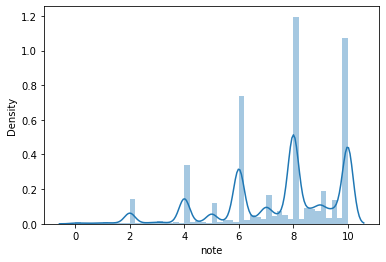

In [7]:
sns.distplot(df_avis["note"])   

Distribution par utilisateur

<AxesSubplot:xlabel='note', ylabel='Density'>

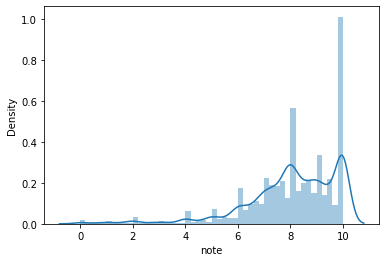

In [8]:
user_means = df_avis.groupby("author")["note"].mean()
sns.distplot(user_means)

Distribution par jeu

<AxesSubplot:xlabel='note', ylabel='Density'>

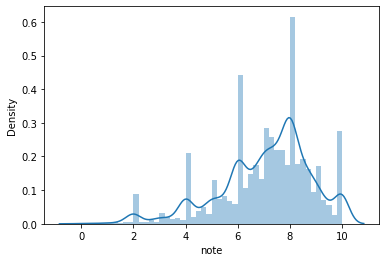

In [9]:
item_means = df_avis.groupby("title")["note"].mean()
sns.distplot(item_means)

Vérification que chaque author n'a donné qu'un seul avis pour un jeu donné : 

In [10]:
for i in df_avis.groupby(['author', 'title']):
    if len(i[1]) > 1:
        print("Duplicated author and title")
        df_avis_unique = traitement_reco.delete_dup(df_avis)
        break

Duplicated author and title


In [11]:
print("Nombre d'avis dupliqués : ", len(df_avis) - len(df_avis_unique))

Nombre d'avis dupliqués :  172


Finalement il n'y a pas de doublons

## Collaborative filtering

In [12]:
nb_avis_min = 5

In [13]:
u,df_avis_filter = traitement_reco.clean_user(df_avis_unique)
g,df_avis_filter = traitement_reco.clean_game(df_avis_filter)
while u!=0 and g!=0 :
    u,df_avis_filter = traitement_reco.clean_user(df_avis_filter)
    g,df_avis_filter = traitement_reco.clean_game(df_avis_filter)

In [14]:
game= np.unique(df_avis_unique["title"])
users= np.unique(df_avis_unique["author"])

game_filtred = np.unique(df_avis_filter["title"])
users_filtred = np.unique(df_avis_filter["author"])

In [15]:
print("On a eliminé", 100 * (len(users) - len(users_filtred)) / len(users), "% des utilisateurs")
print("On a eliminé", 100 * (len(game) - len(game_filtred)) / len(game), "% des jeux")

On a eliminé 66.75475299126477 % des utilisateurs
On a eliminé 54.8043701559436 % des jeux


On a eliminé 66.76209351831461 % des utilisateurs

On a eliminé 55.36759326993416 % des jeux

<AxesSubplot:xlabel='note', ylabel='Density'>

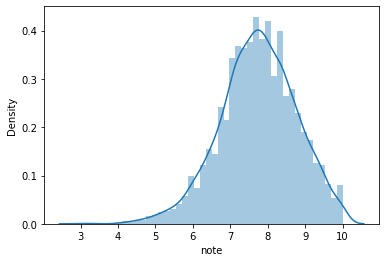

In [16]:
g_users = df_avis_filter.groupby("author")["note"].mean()
sns.distplot(g_users[users_filtred])

<AxesSubplot:xlabel='note', ylabel='Density'>

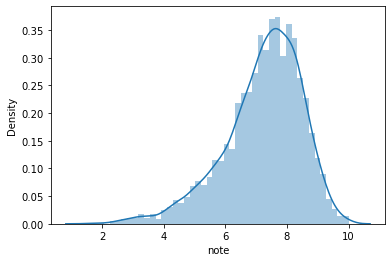

In [17]:
g_game = df_avis_filter.groupby("title")["note"].mean()
sns.distplot(g_game[game_filtred])

In [18]:
train_ratings, test_ratings = train_test_split(df_avis_filter, test_size=0.2)

In [19]:
data = Dataset.load_from_df(train_ratings, Reader(rating_scale=(0, 10)))

### Baseline algorithm

In [ ]:
bs_model = BaselineOnly()
bs_model.fit(data.build_full_trainset())

In [ ]:
test_ratings["baseline_pred"] = test_ratings.apply(lambda u_item : prediction.model_pred(bs_model, u_item), axis=1)
test_ratings

### SVD algorithm

Par défaut dans SVD n_factors (Z) est à 100 et n_epoch est à 20
On va chercher une valeur optimale pour les deux en utilisant GridSearchCV

In [ ]:
param_grid = {'n_factors':list(range(50, 401, 20))}

svd_model = prediction.gs_pred(data, SVD, param_grid)

test_ratings["svd_pred"] = test_ratings.apply(lambda u_item : prediction.model_pred(svd_model, u_item), axis=1)
test_ratings 

### KNN Basic

In [ ]:
param_grid = {'k': list(range(5, 51, 2)), 'verbose': [False]}

knn_pred = prediction.gs_pred(data, KNNBasic, param_grid)

test_ratings["knnBasic_pred"] = test_ratings.apply(lambda u_item : prediction.model_pred(knn_pred, u_item), axis=1)
test_ratings 

### SlopeOne

In [ ]:
slope_one_model = SlopeOne()
slope_one_model.fit(data.build_full_trainset())

In [ ]:
test_ratings["slopeOne_pred"] = test_ratings.apply(lambda u_item : prediction.model_pred(slope_one_model, u_item), axis=1)
test_ratings 

### SVD ++

In [ ]:
param_grid = {'n_factors':list(range(50, 401, 20))}

svdpp_model = prediction.gs_pred(data, SVDpp, param_grid)

test_ratings["svdpp_pred"] = test_ratings.apply(lambda u_item : prediction.model_pred(svdpp_model, u_item), axis=1)
test_ratings 

### Meilleur algo au sens des MSE

In [ ]:
def mse(predictions,truth):
    return ((predictions - truth)**2).mean()

In [ ]:
results = {}

results["baseline"] = mse(test_ratings["baseline_pred"], test_ratings["note"])
results["svd"] = mse(test_ratings["svd_pred"], test_ratings["note"])
results["knnBasic"] = mse(test_ratings["knnBasic_pred"], test_ratings["note"])
results["slopeOne"] = mse(test_ratings["slopeOne_pred"], test_ratings["note"])
results["svdpp"] = mse(test_ratings["svdpp_pred"], test_ratings["note"])

results

In [ ]:
algo_min = min(results, key=results.get)
print("L'algorithme qui minimise la mse est :", algo_min, "avec une valeur de", results[algo_min])

## Création d'un systeme de recommandation pour un utlisateur :

In [ ]:
def basic_recommand_games(model, user, games, df, nb_games=3):
    scores = []
    
    user_games = list(df[df["author"] == user]["title_id_jeu"])
    
    for game in games:
        if game in user_games:
            scores.append(0)
            continue
        
        prediction = model.predict(user, game)
        scores.append(prediction.est)
    
    scores = np.array(scores)
    i_sort = np.argsort(-scores)
    return games[i_sort[:nb_games]]
        

In [ ]:
basic_recommand_games(svd_model, "prunelles", games, df_avis)

In [ ]:
basic_recommand_games(bs_model, "prunelles", games, df_avis)

In [ ]:
basic_recommand_games(svdpp_model, "prunelles", games, df_avis)

In [ ]:
basic_recommand_games(slope_one_model, "prunelles", games, df_avis)

In [ ]:
basic_recommand_games(knn_pred, "prunelles", games, df_avis)